In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

In [3]:
#clustering
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
from sklearn.cluster import KMeans
import time
from pandas.plotting import scatter_matrix
%matplotlib inline
sns.set_context('talk')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

## Market Cluster Analysis

### Decide the number of games included in analysis

In [4]:
#data pre-processing
colnames=['user_id','game_title', 'behavior_name','value','temp'] 
users = pd.read_csv("steam-200k.csv",header=None,names=colnames,
                    usecols=['user_id','game_title', 'behavior_name','value'])
#remove duplicated purchase
users.drop_duplicates(subset=['user_id','game_title','behavior_name'], keep='first', inplace=True)
users.head()

,user_id,game_title,behavior_name,value
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0
1,151603712,The Elder Scrolls V Skyrim,play,273.0
2,151603712,Fallout 4,purchase,1.0
3,151603712,Fallout 4,play,87.0
4,151603712,Spore,purchase,1.0


In [5]:
#number of users
condi = users.behavior_name == 'purchase'
users[condi].user_id.nunique()

12393

In [6]:
#number of games
users.game_title.nunique()

5155

**We decided to include the top 289 games by purchase time in user clusering analysis**   

Why 289?

In [7]:
# rank by number of purchase
condi = users.behavior_name == 'purchase'
top_games = users[condi].groupby(['game_title'])['user_id'].count().sort_values(ascending=False)
top_games.head()
#len(top_games)

game_title
Dota 2                             4841
Team Fortress 2                    2323
Unturned                           1563
Counter-Strike Global Offensive    1412
Half-Life 2 Lost Coast              981
Name: user_id, dtype: int64

<Axes: xlabel='game_title'>

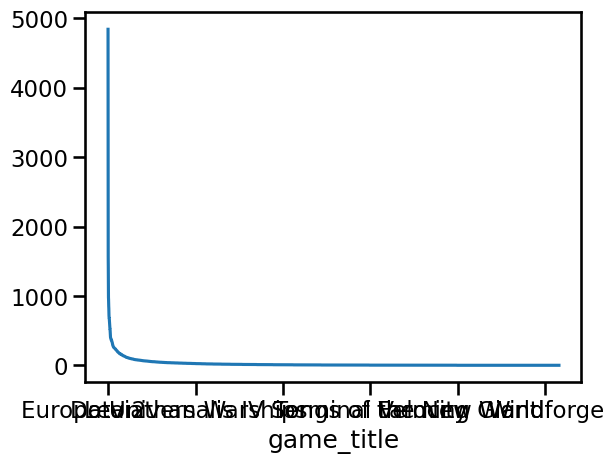

In [8]:
#overview
top_games.plot()

<Axes: xlabel='game_title'>

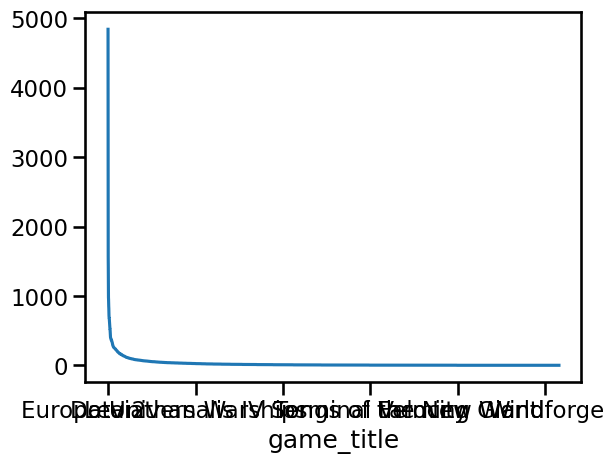

In [9]:
top_games.plot()

Number of purchase drops dramatically

In [10]:
#Filter out games less than 90 purchases (1% of total user population)
len(top_games.where(top_games >= 90).dropna())

289

**back to work**

In [13]:
#filter data set by top 289 games only
top_games_list = list(top_games.index[:289])
users = users[users.game_title.isin(top_games_list)]
users.user_id=users.user_id.astype('str')
users

,user_id,game_title,behavior_name,value
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0
1,151603712,The Elder Scrolls V Skyrim,play,273.0
2,151603712,Fallout 4,purchase,1.0
3,151603712,Fallout 4,play,87.0
6,151603712,Fallout New Vegas,purchase,1.0
...,...,...,...,...
199991,128470551,Fallen Earth,play,2.4
199992,128470551,Magic Duels,purchase,1.0
199993,128470551,Magic Duels,play,2.2
199996,128470551,Grand Theft Auto Vice City,purchase,1.0


In [14]:
test = userbyitem
test.plot()

NameError: name 'userbyitem' is not defined

In [ ]:
#output game list to manually assign genre to each game
#pd.Series(top_games_list).to_csv('top_games_list.csv')

In [15]:
from pandas.api.types import is_numeric_dtype
def remove_outlier(df):
    low = .05
    high = .95
    quant_df = df.quantile([low, high])
    for name in list(df.columns):
        if is_numeric_dtype(df[name]):
            df = df[ (df[name] < quant_df.loc[high, name])]
    return df

### Change the dataset to user vs hours played pivot table

In [17]:
user_play = users[users['behavior_name'] == 'play'].copy()
userbyitem = pd.DataFrame(index=user_play['user_id'].unique(), columns=user_play['game_title'].unique())

for i in range(len(user_play)):
    user_id = user_play.iloc[i]['user_id']
    game_title = user_play.iloc[i]['game_title']
    userbyitem.loc[user_id,game_title] = user_play.iloc[i]['value']
    
#take out users that haven't played at least 3 games
userbyitem = userbyitem[(~userbyitem.isnull()).sum(axis=1) >= 3]

#NA -> 0
userbyitem.fillna(0, inplace = True)

#total hrs played - added as a clusering factor to distinguish hardcore players/light players
userbyitem['Total_Hrs_Played'] = userbyitem.sum(axis=1)

In [18]:
#number of users finally
len(userbyitem)

2956

In [19]:
userbyitem.Total_Hrs_Played.describe()

count     2956.000000
mean       703.697530
std       1048.889834
min          0.400000
25%         71.700000
50%        299.400000
75%        869.075000
max      10853.200000
Name: Total_Hrs_Played, dtype: float64

### Scale values to `range(0,100) `

In [20]:
scaler_mm = MinMaxScaler(feature_range = (0, 100))
userbyitem_mm = scaler_mm.fit_transform(userbyitem)
userbyitem_mm = pd.DataFrame(userbyitem_mm,columns = userbyitem.columns)

### Cluster

**determine optimal k** 

Use elbow plot and inertia as criterion  
Inertia: It is the sum of squared distances of samples to their closest cluster center   
[Elbow Method for optimal value of k in KMeans](https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/)

In [21]:
def get_inertias(max_k, dataset):
    '''
    input max k value, dataset to do clustering on
    output inertias on different k
    '''
    inertia_dict = {}
    for k in range(1, max_k+1):
        model = KMeans(n_clusters=k).fit(dataset)
        inertia_dict[k] = model.inertia_    
    inertia_tuples = [(k, v) for k, v in inertia_dict.items()] 

    return inertia_tuples

In [22]:
def elbow_plot(inertias):
    plt.figure(figsize=(12, 8))
    plt.plot(*zip(*inertias))
    plt.title('Elbow Plot')
    plt.xlabel('k')
    plt.ylabel('Jarak')
    plt.xticks(range(1, len(inertias)+1))
    #plt.axvline(x=10, color = 'red')
    plt.grid(True)

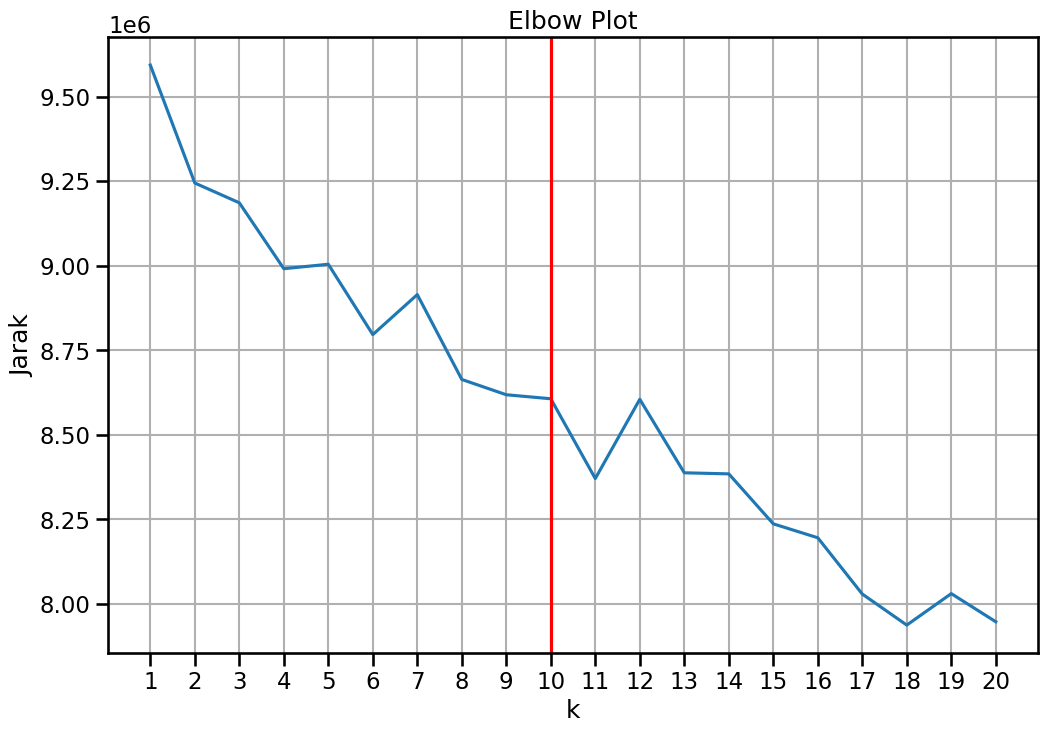

In [23]:
elbow_plot(get_inertias(20, userbyitem_mm))
plt.axvline(x=10, color = 'red')

**optimal k = 10**

In [24]:
#reset userbyitem_mm
scaler_mm = MinMaxScaler(feature_range=(0,100))
userbyitem_mm = scaler_mm.fit_transform(userbyitem)
userbyitem_mm = pd.DataFrame(userbyitem_mm,columns = userbyitem.columns)

k = 10
model = KMeans(n_clusters=k)
model.fit(userbyitem_mm)
userbyitem_mm['cluster'] = pd.Series(model.fit_predict(userbyitem_mm))
#userbyitem_mm.head()

**sizes of clusters**

In [25]:
print(userbyitem_mm.Total_Hrs_Played)

0        3.721620
1        1.186791
2        6.190108
3        1.676065
4        0.408190
          ...    
2951     2.644479
2952    21.808197
2953    18.578616
2954     0.171384
2955     0.668952
Name: Total_Hrs_Played, Length: 2956, dtype: float64


In [26]:
userbyitem_mm.groupby('cluster').size()

cluster
0      16
1    2360
2       3
3      30
4      45
5       1
6     267
7     188
8       1
9      45
dtype: int64

In [27]:
def explain_cluster(data):
    '''
    input clustering data
    output the most 3 preferred genres in each cluster and statistics
    '''
    stats = data.groupby('cluster').mean().round(2)
    
    #rank every row
    stats1 = stats.drop(columns = 'Total_Hrs_Played')
    arr = np.argsort(-stats1.values, axis=1)
    row_rank = pd.DataFrame(stats1.columns[arr], index=stats1.index)
    row_rank = row_rank[[0, 1, 2]].rename(columns = {0:'Dominant Genre/Game', 
                                                        1:'2nd Preferred', 
                                                        2:'Might Also Play'})
    row_rank = row_rank.join(stats['Total_Hrs_Played'])
    row_rank = row_rank.rename(columns = {'Total_Hrs_Played':'User Stickness'})
    stats = stats.rename(columns = {'Total_Hrs_Played':'User Stickness'})

    #add cluster size
    sizes = data.groupby('cluster').size()
    sizes.name = 'Cluster Size'
    row_rank = row_rank.join(sizes)

    return stats,row_rank

### Cluster details (genre level)
1. The top 3 mostly preferred genres
2. User stickiness on the top 3 genres (sum of mean hours played scaled in `range(0,100)`

In [28]:
game_category = pd.read_csv('game_category.csv',index_col='Game')
gg_dict = game_category.to_dict()['Genre']

In [29]:
new_ubi = userbyitem_mm.copy()
new_ubi_cat = new_ubi.rename(columns=gg_dict)
new_ubi_cat = new_ubi_cat.drop('cluster', axis = 1)\
               .groupby(new_ubi_cat.drop('cluster', axis = 1).columns.values, axis = 1).sum().round(2)\
               .join(userbyitem_mm['cluster'])

In [39]:
genre_stats,genre_rank = explain_cluster(new_ubi_cat)
genre_rank.sort_values(['Dominant Genre/Game', '2nd Preferred'], inplace = True)
genre_rank

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

### Cluster details (game level)
1. The top 3 mostly played games
2. User stickiness on the top 3 games (mean hours played scaled in `range(0,100)`